# Batch Effect

This part shows how to integrate data of different batches. As integration works by adjusting the principal components, this function should be performed after PCA.

## Integration

### Reading data

Two batches of experiment data stored in GEM files are uesd here, which are lasso results from their original GEF file.

Please download our [example data](http://116.6.21.110:8090/share/c5d9e7f3-7d66-4154-87e1-a740f4bb4dbc).

In [1]:
import stereo as st
import warnings
warnings.filterwarnings('ignore')

In [2]:
input_file_1 = '../data/SS200000132BR_A1.bin1.Lasso.gem.gz'
input_file_2 = '../data/SS200000132BR_A2.bin1.Lasso.gem.gz'

data1 = st.io.read_gem(input_file_1)
data2 = st.io.read_gem(input_file_2)

[2024-05-08 04:02:18][Stereo][244929][MainThread][140462125991744][reader][159][INFO]: the martrix has 10762 cells, and 24687 genes.
[2024-05-08 04:03:22][Stereo][244929][MainThread][140462125991744][reader][159][INFO]: the martrix has 10464 cells, and 24966 genes.


### Preprocessing

Before integrating batches, we need to do basic preprocessing for each batch, including quality control and filtering.

In [3]:
data1.tl.cal_qc()
data2.tl.cal_qc()

[2024-05-08 04:03:23][Stereo][244929][MainThread][140462125991744][st_pipeline][41][INFO]: start to run cal_qc...
[2024-05-08 04:03:24][Stereo][244929][MainThread][140462125991744][st_pipeline][44][INFO]: cal_qc end, consume time 0.5445s.
[2024-05-08 04:03:24][Stereo][244929][MainThread][140462125991744][st_pipeline][41][INFO]: start to run cal_qc...
[2024-05-08 04:03:24][Stereo][244929][MainThread][140462125991744][st_pipeline][44][INFO]: cal_qc end, consume time 0.5038s.


Draw scatter plots to observe the distribution, and set appropriate parameters. Filter cells or genes by `st.tl.filter_cells` or `st.tl.filter_genes`.

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

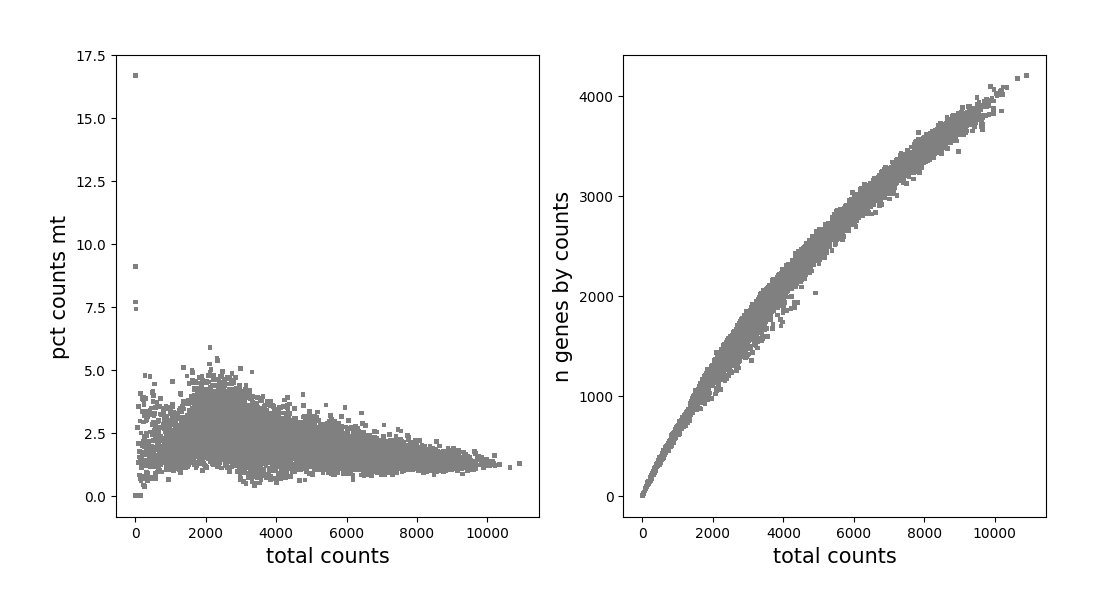

In [4]:
# plot before filtering

data1.plt.genes_count()

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

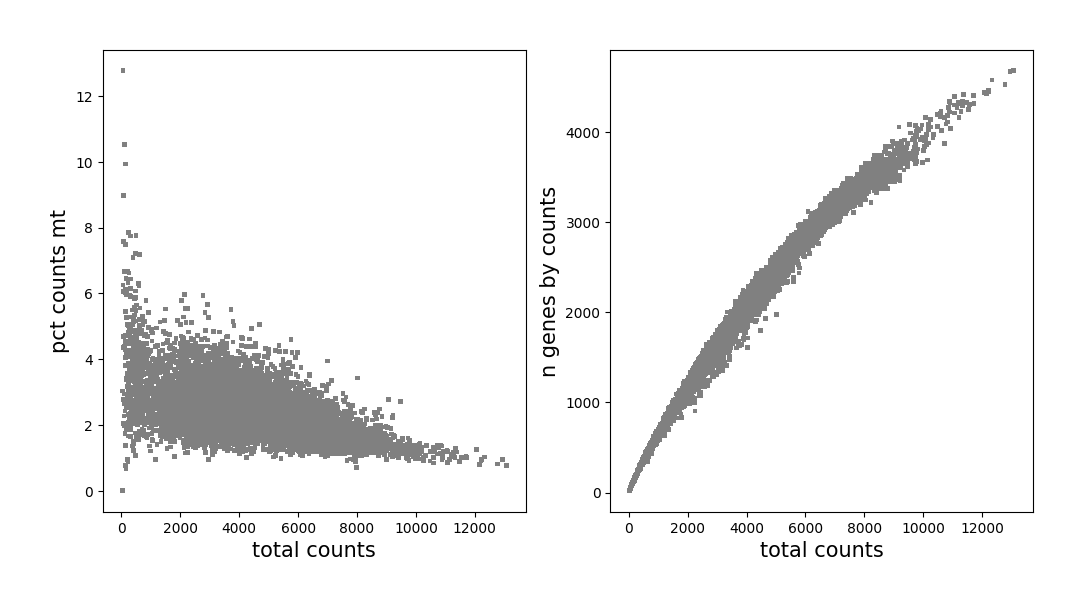

In [5]:
# plot before filtering

data2.plt.genes_count()

In [6]:
# filter cells 

data1.tl.filter_cells(max_n_genes_by_counts=4000, pct_counts_mt=5, inplace=True)
data2.tl.filter_cells(max_n_genes_by_counts=4500, pct_counts_mt=7, inplace=True)

[2024-05-08 04:03:25][Stereo][244929][MainThread][140462125991744][st_pipeline][41][INFO]: start to run filter_cells...
[2024-05-08 04:03:26][Stereo][244929][MainThread][140462125991744][st_pipeline][44][INFO]: filter_cells end, consume time 0.3405s.
[2024-05-08 04:03:26][Stereo][244929][MainThread][140462125991744][st_pipeline][41][INFO]: start to run filter_cells...
[2024-05-08 04:03:26][Stereo][244929][MainThread][140462125991744][st_pipeline][44][INFO]: filter_cells end, consume time 0.3792s.


StereoExpData object with n_cells X n_genes = 10448 X 24966
bin_type: bins
bin_size: 100
offset_x = 3975
offset_y = 8625
cells: ['cell_name', 'total_counts', 'n_genes_by_counts', 'pct_counts_mt']
genes: ['gene_name', 'n_cells', 'n_counts', 'mean_umi']
result: []

### Processing on MSData

Using Multi-sample data structure to process.

In [7]:
from stereo.core.ms_data import MSData
from stereo.core.ms_pipeline import slice_generator

ms_data = MSData(_data_list=[data1, data2])
# you can also create ms_data by `data1 + data2`
ms_data

ms_data: {'0': (10739, 24687), '1': (10448, 24966)}
num_slice: 2
names: ['0', '1']
obs: []
var: []
relationship: other
var_type: intersect to 0
mss: []

### Normalization

Normalization should be finished before PCA. We usually run a combination of `normalize_total` and `log1p`.

In [8]:
# Since normalization will change the expression matrix, save raw data beforehand.
# data.tl.raw_checkpoint()

ms_data.tl.normalize_total(scope=slice_generator[:], mode='integrate')
ms_data.tl.log1p(scope=slice_generator[:], mode='integrate')

[2024-05-08 04:03:27][Stereo][244929][MainThread][140462125991744][ms_pipeline][173][INFO]: data_obj(idx=0) in ms_data start to run normalize_total
[2024-05-08 04:03:27][Stereo][244929][MainThread][140462125991744][st_pipeline][41][INFO]: start to run normalize_total...
[2024-05-08 04:03:28][Stereo][244929][MainThread][140462125991744][st_pipeline][44][INFO]: normalize_total end, consume time 0.5252s.
[2024-05-08 04:03:28][Stereo][244929][MainThread][140462125991744][ms_pipeline][173][INFO]: data_obj(idx=0) in ms_data start to run log1p
[2024-05-08 04:03:28][Stereo][244929][MainThread][140462125991744][st_pipeline][41][INFO]: start to run log1p...
[2024-05-08 04:03:28][Stereo][244929][MainThread][140462125991744][st_pipeline][44][INFO]: log1p end, consume time 0.3146s.


### PCA

In [9]:
ms_data.tl.pca(scope=slice_generator[:], mode='integrate', use_highly_genes=False, n_pcs=50, res_key='pca')

[2024-05-08 04:03:28][Stereo][244929][MainThread][140462125991744][ms_pipeline][173][INFO]: data_obj(idx=0) in ms_data start to run pca
[2024-05-08 04:03:28][Stereo][244929][MainThread][140462125991744][st_pipeline][41][INFO]: start to run pca...
[2024-05-08 04:03:28][Stereo][244929][MainThread][140462125991744][dim_reduce][78][WARNING]: svd_solver: auto can not be used with sparse input.
Use "arpack" (the default) instead.
[2024-05-08 04:06:08][Stereo][244929][MainThread][140462125991744][st_pipeline][44][INFO]: pca end, consume time 159.9640s.


### Integrating

Integrate data from different batches, through adjusting PCA result specified by `pca_res_key`, and rememer to label composite PCA result stored into `res_key`.

In [10]:
ms_data.tl.batches_integrate(scope=slice_generator[:], mode='integrate', pca_res_key='pca', res_key='pca_integrated')

[2024-05-08 04:06:08][Stereo][244929][MainThread][140462125991744][ms_pipeline][173][INFO]: data_obj(idx=0) in ms_data start to run batches_integrate
[2024-05-08 04:06:08][Stereo][244929][MainThread][140462125991744][st_pipeline][41][INFO]: start to run batches_integrate...
2024-05-08 04:06:13,954 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2024-05-08 04:06:20,052 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2024-05-08 04:06:26,252 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2024-05-08 04:06:32,093 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations
[2024-05-08 04:06:32][Stereo][244929][MainThread][140462125991744][st_pipeline][44][INFO]: batches_integrate end, consume time 23.6217s.


### UMAP

After integrating, we can perform UMAP base on the composite PCA result.

In [11]:
ms_data.tl.neighbors(scope=slice_generator[:], mode='integrate', pca_res_key='pca_integrated', n_pcs=50, res_key='neighbors_integrated')
ms_data.tl.umap(scope=slice_generator[:], mode='integrate', pca_res_key='pca_integrated', neighbors_res_key='neighbors_integrated', res_key='umap_integrated')
ms_data.plt.batches_umap(scope=slice_generator[:], mode='integrate', res_key='umap_integrated')

[2024-05-08 04:06:32][Stereo][244929][MainThread][140462125991744][ms_pipeline][173][INFO]: data_obj(idx=0) in ms_data start to run neighbors
[2024-05-08 04:06:32][Stereo][244929][MainThread][140462125991744][st_pipeline][41][INFO]: start to run neighbors...
[2024-05-08 04:06:50][Stereo][244929][MainThread][140462125991744][st_pipeline][44][INFO]: neighbors end, consume time 18.1904s.
[2024-05-08 04:06:50][Stereo][244929][MainThread][140462125991744][ms_pipeline][173][INFO]: data_obj(idx=0) in ms_data start to run umap
[2024-05-08 04:06:50][Stereo][244929][MainThread][140462125991744][st_pipeline][41][INFO]: start to run umap...


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


[2024-05-08 04:07:06][Stereo][244929][MainThread][140462125991744][st_pipeline][44][INFO]: umap end, consume time 16.4866s.
[2024-05-08 04:07:06][Stereo][244929][MainThread][140462125991744][ms_pipeline][173][INFO]: data_obj(idx=0) in ms_data start to run batches_umap


Column
    [0] Markdown(str)
    [1] Row
        [0] Column
            [0] Bokeh(Figure)
        [1] Column
            [0] Row
                [0] Bokeh(Figure)
                [1] Bokeh(Figure)

### Clustering

In [12]:
ms_data.tl.leiden(scope=slice_generator[:], mode='integrate', neighbors_res_key='neighbors_integrated', res_key='leiden')

[2024-05-08 04:07:07][Stereo][244929][MainThread][140462125991744][ms_pipeline][173][INFO]: data_obj(idx=0) in ms_data start to run leiden
[2024-05-08 04:07:07][Stereo][244929][MainThread][140462125991744][st_pipeline][41][INFO]: start to run leiden...
[2024-05-08 04:07:13][Stereo][244929][MainThread][140462125991744][pipeline_utils][27][INFO]: Can not find raw data, the data which may have been normalized will be used.
[2024-05-08 04:07:13][Stereo][244929][MainThread][140462125991744][st_pipeline][44][INFO]: leiden end, consume time 6.6618s.


[2024-05-08 04:07:13][Stereo][244929][MainThread][140462125991744][ms_pipeline][173][INFO]: data_obj(idx=0) in ms_data start to run cluster_scatter


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

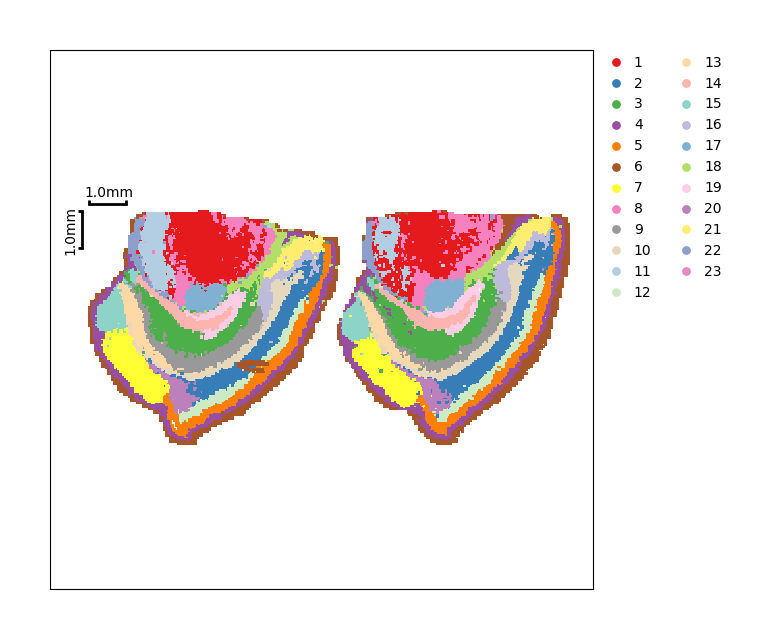

In [13]:
ms_data.plt.cluster_scatter(scope=slice_generator[:], mode='integrate', res_key='leiden', reorganize_coordinate=2)

<div class="alert alert-info">

**Note**

The following part will intentionally show you the significant difference between results of after integrating and without itegrating.

</div>

## Without integration

Compare the UMAP result with before for inspecting the effect of integration.

### Embedding

In [14]:
ms_data.tl.neighbors(scope=slice_generator[:], mode='integrate', pca_res_key='pca', n_pcs=50, res_key='neighbors', n_jobs=-1)
ms_data.tl.umap(scope=slice_generator[:], mode='integrate', pca_res_key='pca', neighbors_res_key='neighbors', res_key='umap')
ms_data.plt.batches_umap(scope=slice_generator[:], mode='integrate', res_key='umap')

[2024-05-08 04:07:14][Stereo][244929][MainThread][140462125991744][ms_pipeline][173][INFO]: data_obj(idx=0) in ms_data start to run neighbors
[2024-05-08 04:07:14][Stereo][244929][MainThread][140462125991744][st_pipeline][41][INFO]: start to run neighbors...
[2024-05-08 04:07:16][Stereo][244929][MainThread][140462125991744][st_pipeline][44][INFO]: neighbors end, consume time 2.0416s.
[2024-05-08 04:07:16][Stereo][244929][MainThread][140462125991744][ms_pipeline][173][INFO]: data_obj(idx=0) in ms_data start to run umap
[2024-05-08 04:07:16][Stereo][244929][MainThread][140462125991744][st_pipeline][41][INFO]: start to run umap...


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


[2024-05-08 04:07:32][Stereo][244929][MainThread][140462125991744][st_pipeline][44][INFO]: umap end, consume time 15.7857s.
[2024-05-08 04:07:32][Stereo][244929][MainThread][140462125991744][ms_pipeline][173][INFO]: data_obj(idx=0) in ms_data start to run batches_umap


Column
    [0] Markdown(str)
    [1] Row
        [0] Column
            [0] Bokeh(Figure)
        [1] Column
            [0] Row
                [0] Bokeh(Figure)
                [1] Bokeh(Figure)

Datasets of two batches are distributed differently on UMAP space, which can be separated from each other obviously.

### Clustering

We can also perform a clustering for a further comparation.

In [15]:
ms_data.tl.leiden(scope=slice_generator[:], mode='integrate', neighbors_res_key='neighbors', res_key='leiden')

[2024-05-08 04:07:33][Stereo][244929][MainThread][140462125991744][ms_pipeline][173][INFO]: data_obj(idx=0) in ms_data start to run leiden
[2024-05-08 04:07:33][Stereo][244929][MainThread][140462125991744][st_pipeline][41][INFO]: start to run leiden...
[2024-05-08 04:07:42][Stereo][244929][MainThread][140462125991744][pipeline_utils][27][INFO]: Can not find raw data, the data which may have been normalized will be used.
[2024-05-08 04:07:42][Stereo][244929][MainThread][140462125991744][st_pipeline][44][INFO]: leiden end, consume time 9.4558s.


[2024-05-08 04:07:42][Stereo][244929][MainThread][140462125991744][ms_pipeline][173][INFO]: data_obj(idx=0) in ms_data start to run cluster_scatter


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

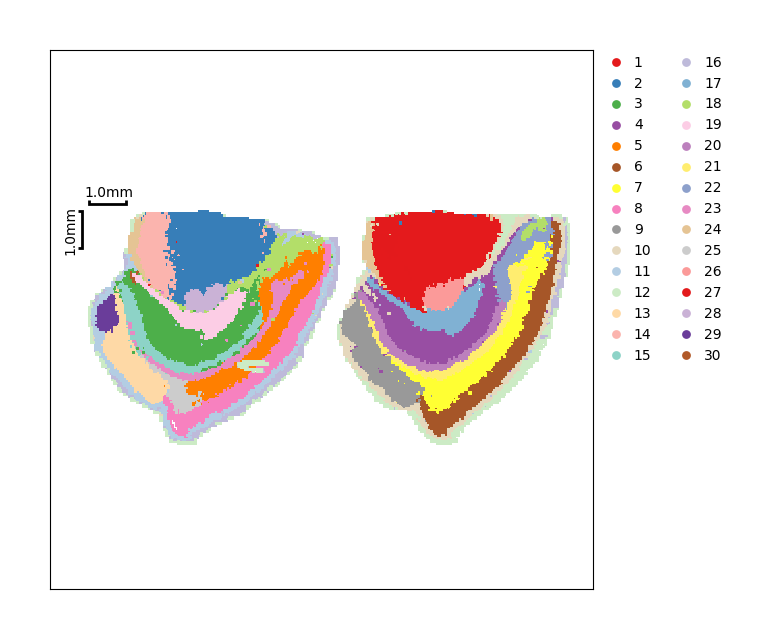

In [16]:
ms_data.plt.cluster_scatter(scope=slice_generator[:], mode='integrate', res_key='leiden', reorganize_coordinate=2)